## **Spindle detection**

#### **Spindles calculation**
**<ul>Define 2 seconds windows</ul>**
**<ul>Animal movement using 2.5 cm/s </ul>**
**<ul>Theta/delta power ration > 2 </ul>**


**Issues:**  Very slow

**Todo:** map channels to recording / statiscal analysis

#### **Import libraries**

In [15]:
import sys  
sys.path.insert(0, 'D:/Beths/')
import os
# import re
import math
import pandas as pd
import numpy as np
from scipy import signal
from tqdm import tqdm
import matplotlib.pyplot as plt

import mne
from mne.filter import filter_data, resample
from pandas_profiling import ProfileReport
import yasa
import pingouin as pg

## Import from my files
from data_lfp import mne_lfp_Axona, load_lfp_Axona
from data_pos import RecPos
from bandPower import *

import warnings
warnings.filterwarnings('ignore')

#### **Reference papers**

##### **Detection of slow-wave sleep, sharp-wave ripples and multi-unit activity bursts**

Paper: Coordinated Emergence of Hippocampal Replay and Theta Sequences during Post-natal Development: 
[https://www.sciencedirect.com/science/article/pii/S0960982219300065]

The brain states slow-wave sleep (SWS), rapid-eye movement sleep (REM) and awake movement were defined following [22
]. A multitaper power spectral density estimate of the hippocampal local field potential (LFP) was derived for **1.6 s windows** , overlapping by 0.8 s (MATLAB function ‘pmtm’). From this, power in the delta and theta bands were calculated in each window. As theta frequency changes during development [18
], theta and delta peak frequencies were calculated for each session, defined as the peak frequency of the fast Fourier transform of the LFP, in the bands 5-11Hz (theta) and 1.5-4Hz (delta). **Mean running speed for each 1.6 s bin was also estimated. In the absence of EMG recordings, we could not unequivocally discriminate between slow wave sleep and quiet immmobility, we therefore restricted all analyses to epochs termed ‘rest’.**

Rest was defined as epochs with running speed < 2.5cm/s , and theta/delta power ratio < 2 and waking movement as theta/delta power ratio > 2 and speed > 2.5cm/s. 
Sharp-wave ripples were detected by first filtering the LFP in the band 100-250Hz. 
The instantaneous power of the filtered LFP was then estimated by calculating the root mean square over 7ms intervals (MATLAB function ‘envelope’ with option ‘rms’). From all LFPs across tetrodes in the CA1 layer, the LFP whose power estimate had the highest standard deviation was then used to define ripple events, as 100ms windows around the peak power, whenever the power was greater than the 99th percentile of all powers in the trial (approximately equal to 4 standard deviations above the mean). Multi-unit activity (MUA) bursts were defined by binning all spikes from CS cells into 1ms bins and smoothing the resulting binned spike train with a Gaussian kernel (s.d. 10ms). MUA events were then defined as crossing of a threshold defined as 3 standard deviations above the mean of the smoothed spike train, with a duration from 100-750ms. Only MUA bursts which temporally overlapped (even in part) with SWR events were included in the replay analysis.

#### **Open Sleep Files**

In [16]:
df = pd.read_csv('data_scheme.csv')
sleep = df.loc[df.sleep == 1]
sleep_files = df.loc[df.sleep == 1, ['folder', 'filename']].agg('/'.join, axis=1).values

In [17]:
sleep_files = [file for file in sleep_files if 'awake' not in file.split('_')]
sleep_files = [file for file in sleep_files if 'awake.set' not in file.split('_')]
filenames = [r.strip().split('/')[-1] for r in sleep_files]
sleep = df[df.filename.isin(filenames)]
sleep_files = sleep.loc[sleep.sleep == 1, ['folder', 'filename']].agg('/'.join, axis=1).values

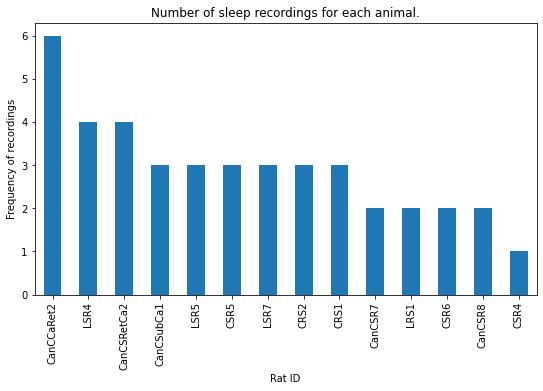

In [18]:
ax = sleep['rat'].value_counts().plot(kind='bar',
                                    figsize=(9,5),
                                    title="Number of sleep recordings for each animal.")
ax.set_xlabel("Rat ID")
ax.set_ylabel("Frequency of recordings")
plt.show()

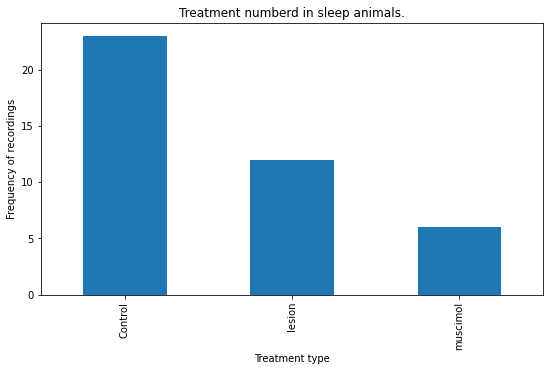

In [19]:
ax = sleep['treatment'].value_counts().plot(kind='bar',
                                    figsize=(9,5),
                                    title="Treatment numberd in sleep animals.")
ax.set_xlabel("Treatment type")

ax.set_ylabel("Frequency of recordings")
plt.show()

##### **Auxiliary functions**

In [70]:
def bandpower(data, low, high, window_sec = 2, sf = 250, relative_power = True):
 
    from scipy.signal import welch
    from scipy.integrate import simps
    scale = 1000 
    lfp_samples = data * scale
    _filter = [1.5, 40]

    # Compute the modified periodogram (Welch)
    nperseg = int(window_sec * sf)
    freqs, psd = welch(lfp_samples, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's
    # rule)
    bp = simps(psd[idx_band], dx=freq_res)

    idx_band = np.logical_and(freqs >= _filter[0], freqs <= _filter[1])
    tp = simps(psd[idx_band], dx=freq_res)

    if relative_power:
        return bp / tp
    return bp


def bandpower_ratio(data, win_sec=2):
   
    b1 = bandpower(data, 1., 4., win_sec)
    b2 = bandpower(data, 5., 11., win_sec)
    if b1 == b2:
        print("Error!")
    bp = b1 / b2
    return bp


def mark_resting(file, mne_data,  tresh=2.5, window_sec = 2): # Mark timestamps were the speed > 2.5 cm/s
    ''' Returns ones for the time windows where the animal was moving with a speed smaller than treshold
    Inputs:
        file(str): filename to be analysed
        tresh(float): speed treshold in cm/s
        window_sec(int): Window in seconds to define resting epochs
    Returns: 
        resting(arr): 1 (ones) for resting 0 (zeros) for movement
    '''
#     cnt = 0 # DEBUG
    
    #Calculate movement based on speed treshold
    file_resting = []
    pos = RecPos(file)
    
#     mne_data = mne_lfp_Axona(file)
    window = window_sec*250
    speed = pos.get_speed()
    moving = np.zeros(len(speed)*5)
    
    for i in range(0, len(speed)): 
        if speed[i] > tresh:
            moving[5*i:5*i+5] = 1
            
    for data in mne_data.get_data():
        result = np.zeros(len(data))
        for i in range(0, len(data) - window, window//2):
            bp = bandpower_ratio(data[i : i + window], window_sec)
            if sum(moving[i : i + window]) == 0 and bp < 2: # running speed < 2.5cm/s , and theta/delta power ratio < 2
                result[i : i + window] = 1 #ones for resting periods
#                 cnt+=1 # DEBUG
        file_resting.append(result)
#     print(f'Total epochs for window = {window_sec}s and tresh = {tresh}cm/s is: {cnt} epochs') # DEBUG
    return np.asarray(file_resting)

    
def create_events(record, events):
    '''Create events on MNE object
    Inputs:
        record(mne_object): recording to add events
        events_time(2D np array): array 0,1 with same lenght of recording dimension (1, lengt(record))
    output: 
    record(mne_object): Record with events added
    '''
    events = np.reshape(events, (1,-1))
    try:
        assert len(record.times) == events.shape[1]
        stim_data = events
        info = mne.create_info(['STI'], record.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(stim_data, info)
        record.add_channels([stim_raw], force_update_info=True)
    except AssertionError as error:
        print(error)
        print('The lenght of events needs to be equal to record lenght.')
    return record

def process_spindles(mne_data):
    ''''''    
    sp = yasa.spindles_detect(mne_data, sf=250, thresh={'rel_pow': 0.2, 'corr': 0.65, 'rms': 2.5}, freq_sp= (12, 15), multi_only=True, verbose='error')
    df = sp.summary()
    return df

def spindles_exclude_resting(mne_data, resting, ch_list = None):
#     resting_df = pd.DataFrame(resting.T, columns = ['ch_'+str(1+i) for i in range(0, len(mne_data.info['ch_names']))])
    resting_df = pd.DataFrame(resting.T, columns = mne_data.info['ch_names'])
    resting_df['time'] = [i*0.004 for i in range(0, len(mne_data))]
    resting_df = resting_df.set_index('time')
    spindles_df = process_spindles(mne_data)
    cnt = 0
    for channel in spindles_df.Channel.unique():  
        sp_times = spindles_df.loc[spindles_df.Channel == channel][['Start', 'End']].values
        for time in sp_times:
            try:
                if sum(resting_df[channel][time[0] : time[1]]) <= 1:
                    spindles_df[(spindles_df.Channel == channel) & (spindles_df.Start == time[0]) & (spindles_df.End == time[1])] = np.nan
            except:
                print(f'Error in channel {channel}')
    return spindles_df

##### **Divide files into treatment groups**

In [21]:
musc = sleep.loc[sleep.treatment == 'muscimol']
control = sleep.loc[sleep.treatment == 'Control']
lesion = sleep.loc[sleep.treatment == 'lesion']
print(f'Muscimol: {len(musc)} recordings in {len(musc.rat.unique())} animals')
print(f'Control: {len(control)} recordings in {len(control.rat.unique())} animals')
print(f'Lesion: {len(lesion)} recordings in {len(lesion.rat.unique())} animals')
msc_files = sleep.loc[sleep.treatment == 'muscimol', ['folder', 'filename']].agg('/'.join, axis=1).values
cnt_files = sleep.loc[sleep.treatment == 'Control', ['folder', 'filename']].agg('/'.join, axis=1).values
les_files = sleep.loc[sleep.treatment == 'lesion', ['folder', 'filename']].agg('/'.join, axis=1).values

Muscimol: 6 recordings in 1 animals
Control: 23 recordings in 9 animals
Lesion: 12 recordings in 4 animals


#### **Debuging**

#### Test mark_resting function:


In [9]:
# mne_data = mne_lfp_Axona(file)
# m1 = mark_resting(file, mne_data, tresh=2.5, window_sec = 2) #(1 for rest, 0 for movement)
# m2 = mark_resting(file, mne_data, tresh=2.5, window_sec = 5)
# m3 = mark_resting(file, mne_data, tresh=4.5, window_sec = 2)

#### **Calculate spindles and filter movement**:

In [91]:
missing_channels = [
    '/mnt/d/Beths/LSR7/sleep/09042018/S2_resting/09042018_LSR7_sleep_partial_2.set',
    '/mnt/d/Beths/LSR7/sleep/09042018/S3_sleep/09042018_LSR7_sleep_sleep_3.set',
    '/mnt/d/Beths/LSR7/sleep/09042018/S4_partial/09042018_LSR7_sleep_parital_4.set']

In [73]:
dfs = []
for file in tqdm(cnt_files):
    mne_data = mne_lfp_Axona(file)
    resting = mark_resting(file, mne_data, tresh=2.5, window_sec = 2)
    dfs.append(spindles_exclude_resting(mne_data, resting))
control_df = pd.concat(dfs)  

100%|██████████| 23/23 [12:35<00:00, 32.87s/it]


In [74]:
dfs = []
for file in tqdm(msc_files):
    mne_data = mne_lfp_Axona(file)
    resting = mark_resting(file, mne_data,  tresh=2.5, window_sec = 2)
    dfs.append(spindles_exclude_resting(mne_data, resting))
musc_df = pd.concat(dfs)  

100%|██████████| 6/6 [03:26<00:00, 34.34s/it]


In [93]:
dfs = []
for file in tqdm(les_files):
    mne_data = mne_lfp_Axona(file)
    if file in missing_channels:
        mne_data.drop_channels(['ch_' + str(i) for i in range(17, 33)])
    resting = mark_resting(file, mne_data,  tresh=2.5, window_sec = 2)
    dfs.append(spindles_exclude_resting(mne_data, resting))
lesion_df = pd.concat(dfs)  

100%|██████████| 12/12 [05:38<00:00, 28.22s/it]


#### **Create Exploratory report**

In [95]:
profile_control = ProfileReport(control_df, title="Pandas Profiling Report")
profile_lesion = ProfileReport(lesion_df, title="Pandas Profiling Report")
profile_musc = ProfileReport(musc_df, title="Pandas Profiling Report")

In [96]:
profile_lesion.to_file("lesion.html")
profile_musc.to_file("muscimol.html")
profile_control.to_file("control.html")

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### **Statistical analysis**